## If you are new to Python

- I will include detailed comments in this demo describing what the code does.
- If you want a more in depth guide to using Python for data analysis and data science, check out the Python Data Science Handbook: https://jakevdp.github.io/PythonDataScienceHandbook/

In [1]:
#required imports for the demo

#this is the standard notation for importing 3rd party modules in Python

import numpy as np # numpy is a versatile matrix manipulation library
import pandas as pd # pandas allows you to create and manipulate data frames
import matplotlib.pyplot as plt # matplotlib is your main plotting library, inspired by MATLAB
from matplotlib import rcParams, cycler # matplotlib modules for customizing color maps
import seaborn as sns # a library built on top of matplotlib which allows for more customization
from itertools import combinations # allows for versatile and quick iteration

<a id=top></a>
# Contents

### [0](#0)) Installing & importing the modules
### [1](#1)) Loading a project
### [2](#2)) Navigating a project object
### [3](#3)) Spike sorting metrics
### [4](#4)) LFP data
### [5](#5)) Navigating an experiment object
### [6](#6)) Checking the stimulus data
### [7](#7)) Checking the spike data
### [8](#8)) Changing the units of your event times
### [9](#9)) Making stimulus-triggered spike rasters
### [10](#10)) Matching stimulus parameter values to condition IDs
### [11](#11)) Getting events associated with a particular stimulus condition
### [12](#12)) Making correlograms
### [13](#13)) Making population response matricies
### [14](#14)) Temporal smoothing
### [15](#15)) Making tuning curves
### [16](#16)) Mapping receptive fields

<a id=0></a>
## 0) Installing & importing the modules

 - Using Anaconda is highly recommended for using EphysToolkit
 - If you already have an Anaconda environment set up, activate that environment and then paste the following command to install :
 
 ```
     pip install https://github.com/Elsayedaa/EphysToolkit/archive/refs/heads/main.zip
     
 ```
 
 [return to top](#top)

In [2]:
# paste in the following import phrase to import the modules

from ephystoolkit.EphysToolkit import *

<a id=1></a>
## 1) Loading a project
 [return to top](#top)

 - To load a project, use the load_project method and the path to the project folder as a parameter.
 - You will be prompted to give the recording probe type when loading a project.
 - The example project used for this demonstration used a 64M probe, so just type 64M and hit enter.

In [3]:
project = load_project('AE_M027')


            Please enter the probe used in this project. Available probes include: 
            ['64D', '64H', '64M']. 
            If the probe used in your recording is not included in the list, 
            navigate to the folder where the ephystoolkit lirbary is installed. 
            
            If you are using Anaconda on windows, this folder should be located at:
            C:\Users\(username)\conda\envs\(env_name)\lib\site-packages\ephystoolkit
            
            If you are using Anaconda on Linux, this folder should be located at:
            ~/anaconda3/envs/(env_name)/lib/(Python_version)/site-packages/ephystoolkit'
            
            Once you are in the module folder, navigate the to folder called 'probes'
            and copy a csv file mapping your channel ids to their distance from the tip
            of the probe. Each line index should correspond to the channel id. Indexes
            for this purpose start at 1. For reference, check out any of the inc

<a id=2></a>
## 2) Navigating a project object
 [return to top](#top)

- You can navigate through a project by calling the workbook attribute on the project object. The workbook attribute contains a list of dictionaries with each dictionary corresponding to a recording section. The dictionaries come in the following structure:

{

  'section_id': Int - Index of the recording section.

  'spike_sorting_metrics': Pandas dataframe - Contains the spike sorting metrics.

  'lfp_heatmaps': Dictionary - Contains the lfp heatmap across channels at different contrasts of the checkerboard stimulus.

  'depth_data': Pandas dataframe - Contains the distance of each channel of the probe relative to layer 4.

  'blocks': List - Contains a list of recording blocks. 

},

- The list of recording blocks is another list of dictionaries with the following structure:

{

'block_id': int - Index of the recording block.

'experiment', Experiment object - Contains the experiment data for the given block.

},

- In the following sections, we'll go through each of the workbook attributes to get a better understanding of what they contain. First, let's select a recording section by indexing the workbook attribute:

In [4]:
section = project.workbook[0] # selecting a section from the workbook
section.keys() # showing the keys of the section dictionary

dict_keys(['section_id', 'spike_sorting_metrics', 'lfp_heatmaps', 'depth_data', 'blocks'])

- We can display the index of the recording section by using 'section_id':

In [5]:
section['section_id'] # displaying the section id

1

- Each section is a series of recording blocks that were done with the same probe insertion. That means each recording block in a section will have the same clusters (neurons putatively identified by spike sorting). 

<a id=3></a>
## 3) Spike sorting metrics
 [return to top](#top)

- We can take a look at the spike sorting metrics given to these clusters by indexing 'spike_sorting_metrics' in the section dictionary:

In [6]:
metrics = section['spike_sorting_metrics']
metrics

,isolation,noise_overlap
0,0.951821,0.411281
1,0.915394,0.339013
2,0.993831,0.015276
3,0.915394,0.370153
4,0.994125,0.040541
...,...,...
80,0.943302,0.250588
81,0.946240,0.229730
82,0.972385,0.099001
83,0.936545,0.309342


- The noise overlap metric measures how much overlap the cluster has to a cluster composed of randomly sampled spikes from noise. The isolation metric indicates how well isolated a cluster is from other clusters. 
- We typically only include clusters with noise overlap <0.07 and isolation >0.96. 
- We can use these selection criteria to make a boolean index in pandas:

In [7]:
single_units = metrics.loc[ # find the clusters passing criteria
    
    (metrics.isolation > 0.96) 
    & (metrics.noise_overlap < 0.07)
    
].reset_index()

not_single_units = metrics.loc[ # find the clusters NOT passing criteria
    
    (metrics.isolation <= 0.96) 
    & (metrics.noise_overlap >= 0.07)
    
].reset_index()

- We can then plot and label the clusters that pass and do not pass:

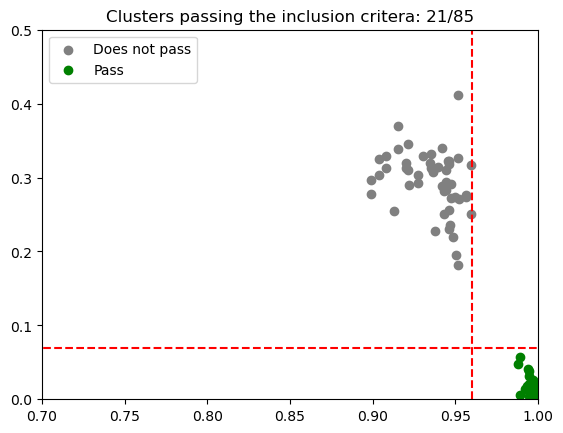

In [8]:
# plot isolation on x axis and noise overlap on y axis with a scatterplot
plt.scatter(not_single_units['isolation'], not_single_units['noise_overlap'], color = 'gray', label = 'Does not pass')
plt.scatter(single_units['isolation'], single_units['noise_overlap'], color = 'green', label = 'Pass')

# draw a horizontal red dashed line at y = 0.07
plt.plot(np.linspace(0,1,457),[0.07]*457, linestyle = '--', color = 'red')

# same as above, but with a vertical line at x = 0.96
plt.plot([0.96]*457, np.linspace(0,1,457), linestyle = '--', color = 'red')

# define the axis limits
plt.xlim(0.7,1)
plt.ylim(0,0.5)
plt.title(f"Clusters passing the inclusion critera: {len(single_units)}/{len(metrics)}")
plt.legend()

<a id=4></a>
## 4) LFP data
 [return to top](#top)

- Next, let's take a look at how to plot LFP data. We can look at the LFP data by using 'lfp_heatmaps'.
- Here, the keys correspond to the x position of a column of recording chanels. 
- In this particular example, 0 corresponds to the first column and 25 corresponds to a column that is displaced horizontally by 25 micrometers. 
- Let's take a look at the first column.

In [9]:
section['lfp_heatmaps'][0].keys()

dict_keys(['contrast0', 'contrast1'])

- Here, the keys correspond to the LFP response at each contrast of the checkerboard stimulus. 
- Let's plot the LFP response to the first contrast. 
- First, we'll get the depths of the channels along the column (from the tip of the probe in micrometers). 
- To do this, we can call the channels_bycol attribute on the project object. 
- We the index the column of interest and use the 'c_depth' key:

In [10]:
depth_info = project.channels_bycol[0]['c_depth']
depth_info

array([1550., 1500., 1450., 1400., 1350., 1300., 1250., 1200., 1150.,
       1100., 1050., 1000.,  950.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   50.,    0.])

- Next we can plot the LFP response to contrast0 by using a heatmap:

Text(0.5, 23.52222222222222, 'Time (ms)')

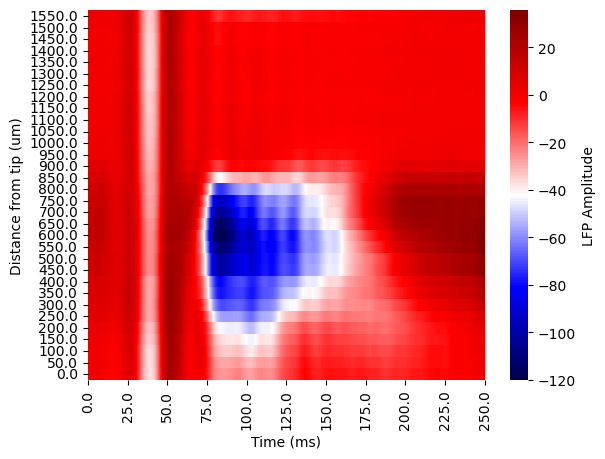

In [11]:
fig, ax = plt.subplots()

sns.heatmap(
    section['lfp_heatmaps'][0]['contrast0'], 
    cmap = 'seismic',
    cbar_kws={'label': 'LFP Amplitude'},
)

yticks = np.arange(len(depth_info))+0.5
ax.set_yticks(yticks)
ax.set_yticklabels(depth_info, rotation = 0)
ax.set_ylabel("Distance from tip (um)")

# There are 250ms of data in the LFP and the recording
# hardware samples 20,000 times per second.
xticks = np.arange(0, 5500, 500)
xticklabels = xticks/20
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Time (ms)")

- You can also get the depth of every channel relative to the LFP sink (typically around layer 4 in visual cortex) by using 'depth_data' on the section dictionary. 
- This is helpful for finding the depth of each recorded cluster.

In [12]:
section['depth_data']

,channel,distance
0,56,973.035
1,10,948.035
2,55,923.035
3,11,898.035
4,54,873.035
...,...,...
59,3,-501.965
60,63,-526.965
61,2,-551.965
62,64,-576.965


<a id=5></a>
## 5) Navigating an experiment object
 [return to top](#top)

- Each project section contains a set of experiment blocks. 
- Each block is a recording session done with a particular visual stimulus. 
- To get a list of the block, index 'blocks' in the section dictionary:

In [13]:
section['blocks']

[{'block_id': 1,
  'experiment': <ephystoolkit.EphysToolkit.load_experiment at 0x7b428ff18dc0>},
 {'block_id': 2,
  'experiment': <ephystoolkit.EphysToolkit.load_experiment at 0x7b4286410e80>},
 {'block_id': 3,
  'experiment': <ephystoolkit.EphysToolkit.load_experiment at 0x7b4286380df0>},
 {'block_id': 4,
  'experiment': <ephystoolkit.EphysToolkit.load_experiment at 0x7b4286380d00>}]

- Each dictionary in this list contains the block id and the experiment object. 
- The first block in this section is a simple sign alternating checkerboard stimulus recording:

In [14]:
ex1 = section['blocks'][0]['experiment']
ex1

<a id=6></a>
## 6) Checking the stimulus data
 [return to top](#top)

- We can use the 'stim_data' attribute of the experiment object to get a dataframe containing key information about the stimulus:
    - Stim_condition_ids: Gives the numerical ID of the stimulus condition that was shown. In this example, there are just two conditions corresponding to each sign of the checkerboard stimulus.
    - stim_start_indicies: The index where the condition appears in the complete stimulus array.
    - stim_start_indicies: The index where the condition disappears in the complete stimulus array.
    - stim_start_times: The time when the condition appears relative to recording start.
    - stim_start_times: The time when the condition disappears relative to recording start.

In [15]:
ex1.stim_data

,stim_condition_ids,stim_start_indicies,stim_stop_indicies,stim_start_times,stim_stop_times
0,1,40918,51569,2045.90,2578.45
1,2,51910,62562,2595.50,3128.10
2,1,62912,73562,3145.60,3678.10
3,2,73912,84562,3695.60,4228.10
4,1,84910,95562,4245.50,4778.10
...,...,...,...,...,...
395,2,4370864,4381524,218543.20,219076.20
396,1,4381863,4392523,219093.15,219626.15
397,2,4392862,4403523,219643.10,220176.15
398,1,4403863,4414524,220193.15,220726.20


<a id=7></a>
## 7) Checking the spike data
 [return to top](#top)
 - Cluster spiking information is retrieved by calling the spike_data attribute.
 - Spiking data is stored as a list of dictionaries.
 - Each dictionary corresponds to a different cluster.
 - The dictionary keys are:
     - 'channel_id': a number corresponding to the channel that picked up the cluster.
     - 'depth': depth of the channel that picked up the cluster.
     - 'spike_index': index of spikes relative to the length of the entire recording
     - 'spike_time': time that a spike occured in unix time.
     - 'rel_spike_time': time of the spike in ms relative to the start of the recording.

In [16]:
ex1.spike_data[0]

{'channel_id': 1,
 'depth': -601.965,
 'spike_index': array([   5148,    5280,    5536, ..., 4439532, 4440313, 4444395],
       dtype=int32),
 'spike_time': array([ -0.74715,  -0.74055,  -0.72775, ..., 220.97205, 221.0111 ,
        221.2152 ], dtype=float32),
 'rel_spike_time': array([   257.4 ,    264.  ,    276.8 , ..., 221976.6 , 222015.65,
        222219.75])}

<a id=8></a>
## 8) Changing the units of your event times
 [return to top](#top)
 - By default, EphysToolkit gives you your event times (stim start, stim stop, rel spike time) in milliseconds. 
 - You can change the units of your event times by using the set_time_unit method on the experiment object.
 - This method takes an argument bin_size: default value argument set to 0.001.
 - You should always give your units in terms of 1 second, ie:
     - 1ms = 0.001
     - 1cs = 0.01
     - 1ds = 0.1
     - 1s  = 1

In [17]:
# get_event_times is a class method, methods are analagous to functions,
# but are functions associated with the class.

# include the argument between () circular brackets
ex1.set_time_unit(bin_size = 0.000001) #event times in microseconds
ex1.set_time_unit(bin_size = 0.001) #event times in milliseconds
ex1.set_time_unit(bin_size = 0.01) #event times in centiseconds
ex1.set_time_unit(bin_size = 0.1) #event times in deciseconds
ex1.set_time_unit(bin_size = 1) #event times in seconds

 - Checking the changes...

In [18]:
#The last line of code changed the unit to seconds, so event times are given in seconds
ex1.stim_data

,stim_condition_ids,stim_start_indicies,stim_stop_indicies,stim_start_times,stim_stop_times
0,1,40918,51569,2.04590,2.57845
1,2,51910,62562,2.59550,3.12810
2,1,62912,73562,3.14560,3.67810
3,2,73912,84562,3.69560,4.22810
4,1,84910,95562,4.24550,4.77810
...,...,...,...,...,...
395,2,4370864,4381524,218.54320,219.07620
396,1,4381863,4392523,219.09315,219.62615
397,2,4392862,4403523,219.64310,220.17615
398,1,4403863,4414524,220.19315,220.72620


In [19]:
# resetting the bin size
ex1.set_time_unit(bin_size = 0.001)

<a id=9></a>
## 9) Making stimulus-triggered spike rasters
 [return to top](#top)

 - First, we select a cluster whose spike times we want to analyze. We can do this using the single_units dataframe we defined earlier to select the unit with the highest isolation score:

In [20]:
single_units.loc[
    (single_units.isolation == single_units.isolation.max())
]

,index,isolation,noise_overlap
7,36,0.999412,0.006757


In [21]:
unit = single_units.loc[
    (single_units.isolation == single_units.isolation.max())
]['index'].values[0]
unit

36

- We can then define a variable with the relative spike times of this unit and also define a variable containing all of the stimulus start times. Since this is a checkerboard recording, each stimulus onset time is just a moment when the sign of the stimulus switched:

In [22]:
spiketimes = ex1.spike_data[unit]['rel_spike_time']
stimtimes = ex1.stim_data['stim_start_times'].values

- You can then use the raster method on the experiment object to make a stimulus triggered raster plot. By default, this method will plot all spikes relative to the stimulus onset across all of its repetitions. The raster method takes 3 arguments:
    - The stims argument takes the array of stimulus onset times
    - The spikes argument takes the array of spike onset times
    - The thresh argument takes a tuple defining the time boundaries around 0 as the stimulus onset.

In [23]:
raster = ex1.raster(
    stims = stimtimes, 
    spikes = spiketimes, 
    thresh = (-500,500) 
)

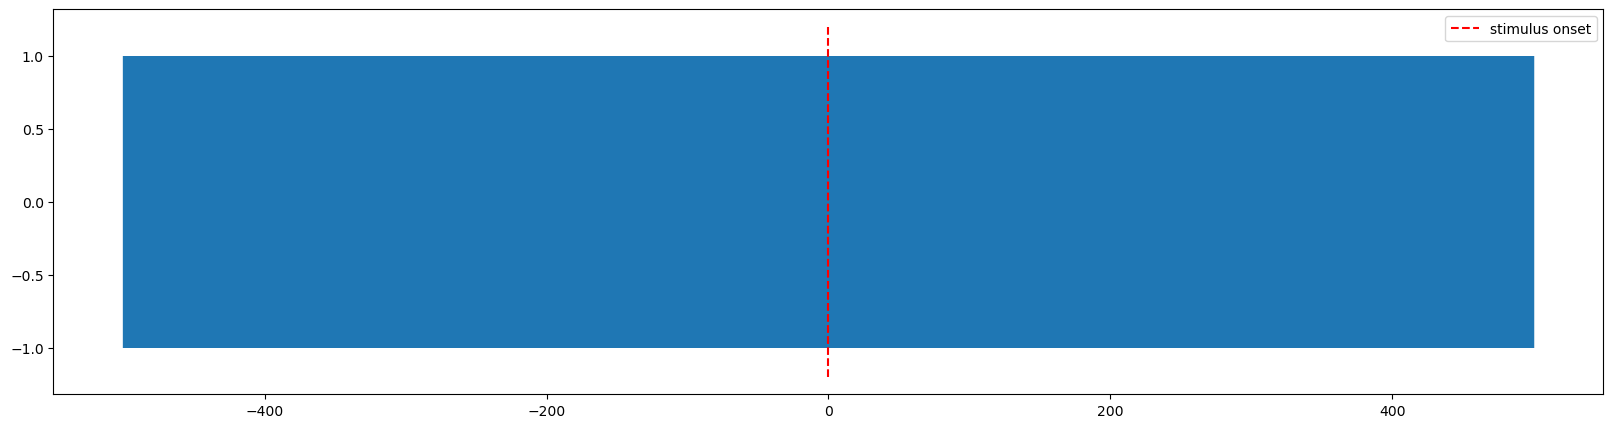

In [24]:
#plot your raster
plt.subplots(figsize = (20,5))
plt.vlines(raster, -1, 1)
plt.vlines(0,-1.2,1.2, linestyle = '--', color = 'red', label = "stimulus onset")
plt.legend()

- You can also make a stimulus triggered spike raster for a single  stimulus repetition by setting the "concatenate" argument equal to "False". This returns a 

In [25]:
raster = ex1.raster(
    stimtimes,
    spiketimes,
    thresh = (-500,500),
    concatenate = False #make an individual raster for each stimulus rep
)

In [26]:
print(f"This experiment repeated the stimulus {len(raster)} times") 

This experiment repeated the stimulus 400 times


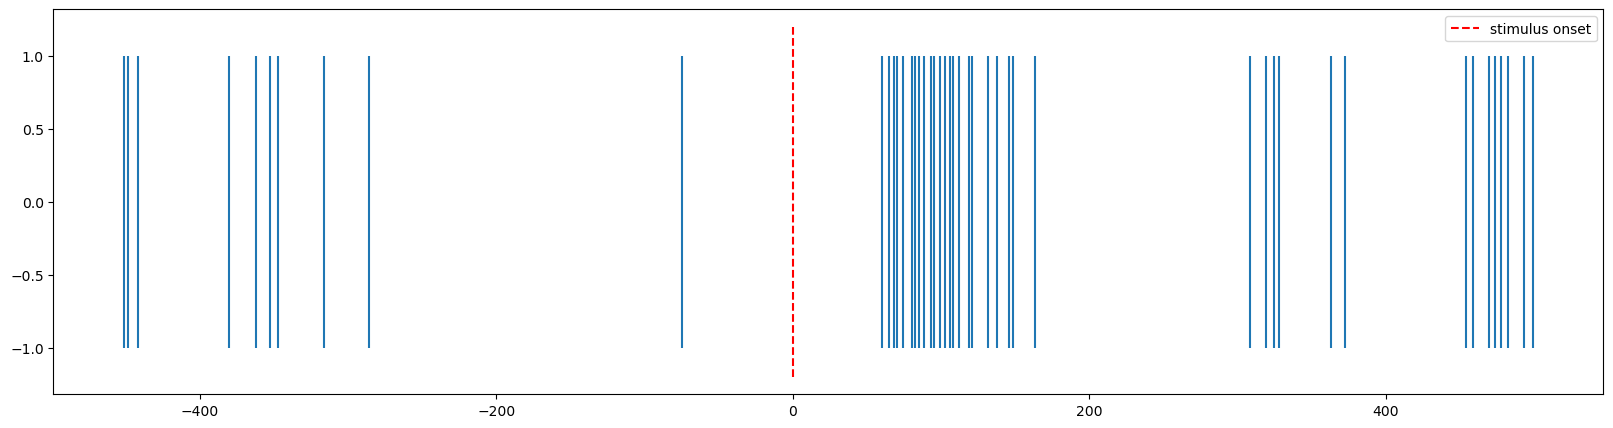

In [27]:
#a raster plot of the response to only the first repetition of the stimulus

plt.subplots(figsize = (20,5))
plt.vlines(raster[0], -1, 1)
plt.vlines(0,-1.2,1.2, linestyle = '--', color = 'red', label = "stimulus onset")
plt.legend()

<a id=10></a>
## 10) Matching stimulus parameter values to condition IDs
 [return to top](#top)

- Most experiments have multiple stimulus conditions. These conditions are typically not automatically given in the stimulus dataframe. 
- Let's take a look at experiment 2 for example, which uses flashing sinusoidal gratings that vary in orientation, phase, and spatial frequency (sf). 
- This is a stimulus that is often used to measure spatiotemporal receptive fields.

In [28]:
ex2 = section['blocks'][1]['experiment']

In [29]:
ex2.stim_data

,stim_condition_ids,stim_start_indicies,stim_stop_indicies,stim_start_times,stim_stop_times
0,333,41039,41044,2051.95,2052.20
1,370,41272,41276,2063.60,2063.80
2,52,41572,41577,2078.60,2078.85
3,373,41904,41909,2095.20,2095.45
4,259,42239,42255,2111.95,2112.75
...,...,...,...,...,...
81595,155,27239006,27239009,1361950.30,1361950.45
81596,99,27239339,27239343,1361966.95,1361967.15
81597,44,27239672,27239675,1361983.60,1361983.75
81598,235,27240007,27240010,1362000.35,1362000.50


- To match the stimulus parameters to their corresponding condition id, you have to use the match_condition_parameters method on the experiment object.
- This method takes a single parameter, the parameter file to the experiment, which is usually a .mat or .log file.

In [30]:
parameter_file = 'ringach_stim_params.mat'

In [31]:
ex2.match_condition_parameters(parameter_file)

In [32]:
ex2.stim_data

,stim_condition_ids,Orientation,Spatial Freq,Phase,stim_start_indicies,stim_stop_indicies,stim_start_times,stim_stop_times
0,333,120.0,0.30,0.00,41039,41044,2051.95,2052.20
1,370,150.0,0.14,0.25,41272,41276,2063.60,2063.80
2,52,0.0,0.24,0.75,41572,41577,2078.60,2078.85
3,373,150.0,0.16,0.00,41904,41909,2095.20,2095.45
4,259,90.0,0.26,0.50,42239,42255,2111.95,2112.75
...,...,...,...,...,...,...,...,...
81595,155,60.0,0.08,0.50,27239006,27239009,1361950.30,1361950.45
81596,99,30.0,0.14,0.50,27239339,27239343,1361966.95,1361967.15
81597,44,0.0,0.20,0.75,27239672,27239675,1361983.60,1361983.75
81598,235,90.0,0.14,0.50,27240007,27240010,1362000.35,1362000.50


- Let's go ahead and match the parameters to all of the experiments included in this recording.

In [33]:
ex3 = section['blocks'][2]['experiment']
ex3.match_condition_parameters('drift_grating_params.log')
ex4 = section['blocks'][3]['experiment']
ex4.match_condition_parameters('natural_img_params.mat')

<a id=11></a>
## 11) Getting events associated with a particular stimulus condition
 [return to top](#top)
- In the section on making stimulus triggered spike rasters, the raster was made relative to all stimulus condition start times. 
- If you want to make a raster relative to a specific stimulus condition, you can specify the start times associated with that condition in the raster method.
- You can get the start times for a specific condition by using the condition_times method on the experiment object.
- This method takes a single parameter: the condition id of the stimulus condition you want to select.
- Let's look for a condition where the spatial frequency is 0.02:

In [34]:
ex2.stim_data.loc[
    (ex2.stim_data['Spatial Freq'] == 0.02)
]

,stim_condition_ids,Orientation,Spatial Freq,Phase,stim_start_indicies,stim_stop_indicies,stim_start_times,stim_stop_times
22,347,150.0,0.02,0.50,48234,48237,2411.70,2411.85
24,277,120.0,0.02,0.00,48907,48910,2445.35,2445.50
51,278,120.0,0.02,0.25,57905,57908,2895.25,2895.40
75,143,60.0,0.02,0.50,65907,65910,3295.35,3295.50
80,144,60.0,0.02,0.75,67573,67576,3378.65,3378.80
...,...,...,...,...,...,...,...,...
81577,75,30.0,0.02,0.50,27233007,27233010,1361650.35,1361650.50
81579,347,150.0,0.02,0.50,27233673,27233677,1361683.65,1361683.85
81583,345,150.0,0.02,0.00,27235006,27235009,1361750.30,1361750.45
81588,210,90.0,0.02,0.25,27236667,27236670,1361833.35,1361833.50


In [35]:
# We'll pick the first condition in the dataframe above

condition = ex2.stim_data.loc[
    (ex2.stim_data['Spatial Freq'] == 0.02)
].stim_condition_ids.values[0]

In [36]:
ex2.condition_times(condition)

{'start': array([   2411.7 ,   23561.85,   26445.1 ,   30295.05,   36478.35,
          37828.3 ,   50344.25,   55610.85,   67244.1 ,   72944.  ,
          93460.65,   94827.35,   98061.15,  128510.85,  133127.  ,
         148727.35,  155893.2 ,  158293.5 ,  176560.3 ,  180743.45,
         185759.95,  188676.6 ,  200392.95,  204093.  ,  207110.3 ,
         214009.6 ,  233210.15,  235093.3 ,  239209.55,  244226.1 ,
         253059.9 ,  255026.5 ,  256793.45,  267659.2 ,  268875.95,
         270759.2 ,  277558.95,  280693.  ,  293659.05,  298925.5 ,
         299042.15,  309659.4 ,  312892.7 ,  316542.3 ,  329491.9 ,
         341058.65,  343524.95,  345158.6 ,  354391.7 ,  366308.35,
         369791.8 ,  370041.7 ,  379441.6 ,  389025.35,  392258.2 ,
         393475.05,  396641.2 ,  400824.65,  404124.6 ,  405908.65,
         408241.7 ,  424825.05,  427624.6 ,  433858.4 ,  440107.5 ,
         446691.1 ,  456641.55,  461107.9 ,  461707.9 ,  462474.8 ,
         470907.65,  476207.4 ,  476274

- You can now make a raster relative to that stimulus condition.

In [37]:
stimtimes = ex2.condition_times(condition)['start']

In [38]:
raster = ex2.raster(
    stimtimes,
    spiketimes,
    thresh = (0,500),
)

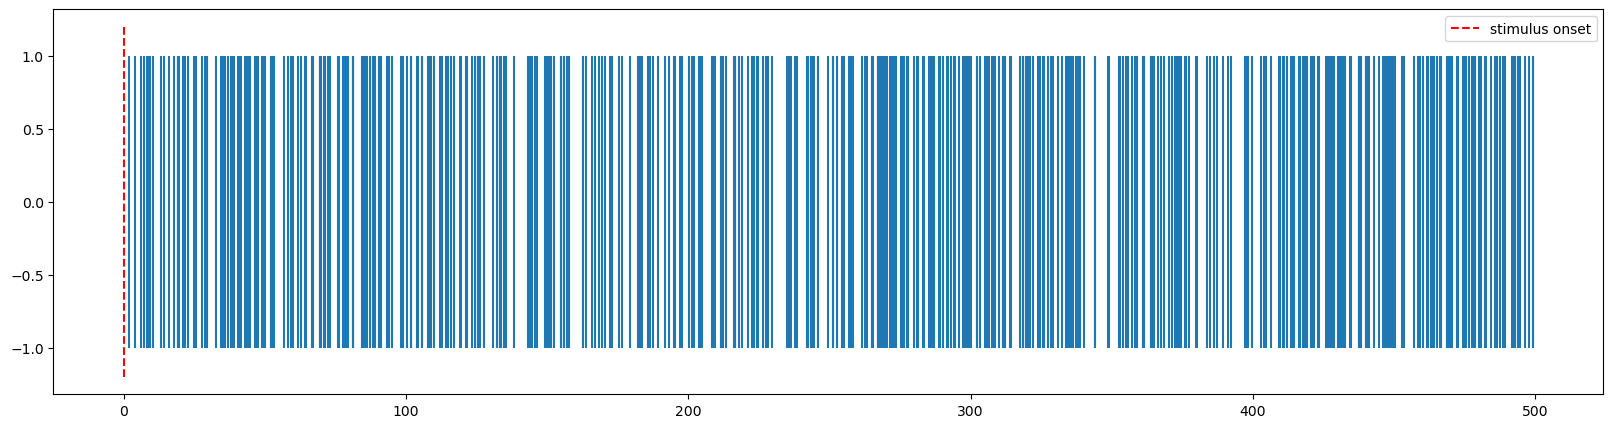

In [39]:
#a raster plot of the response to stimulus condition 1

plt.subplots(figsize = (20,5))
plt.vlines(raster, -1, 1)
plt.vlines(0,-1.2,1.2, linestyle = '--', color = 'red', label = "stimulus onset")
plt.legend()

<a id=12></a>
## 12) Making correlograms
 [return to top](#top)

- You can also make cross correlograms between different clusters using the raster function.
- To do this, enter the spike times of a particular unit as the first argument instead of stimulus onset times.
- This returns a raster with the spikes of the second unit centered around the spikes of the first unit.

In [40]:
# selecting units to analyze

unit_selection = [14, 39, 47, 48]
unit_combos = list(combinations(unit_selection, 2))

In [41]:
u1, u2 = unit_combos[0]
print(f"Making a cross correlogram between units {u1} and {u2}.")

Making a cross correlogram between units 14 and 39.


In [42]:
# getting the unit spike times
unit_1 = ex2.spike_data[u1]['rel_spike_time']
unit_2 = ex2.spike_data[u2]['rel_spike_time']

# making the raster
raster = ex2.raster(
    unit_1,
    unit_2,
    thresh = (-200,200),
)

Text(0.5, 1.0, 'Correlogram of units 14 and 39')

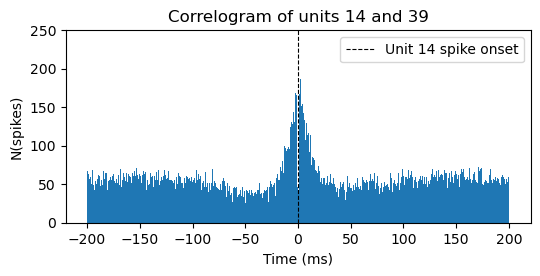

In [43]:
fig, ax = plt.subplots(figsize = (6, 2.5))
h, bins = np.histogram(raster, bins = np.arange(-200,201, 0.8))
bin_centers = (bins[1:] + bins[:-1])/2
ax.bar(bin_centers, h)
ax.plot(
    np.full(400, 0), 
    np.linspace(0,250,400), 
    '--', 
    color = 'black', 
    linewidth = 0.8,
    label = f"Unit {u1} spike onset"
)
ax.set_ylim(0,250)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("N(spikes)")
ax.legend()
ax.set_title(f"Correlogram of units {u1} and {u2}")

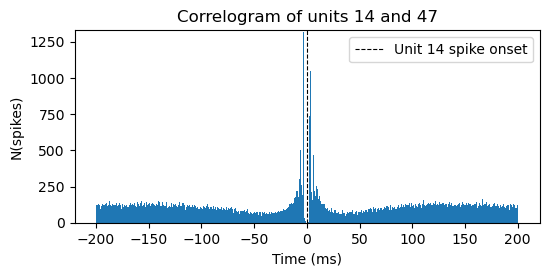

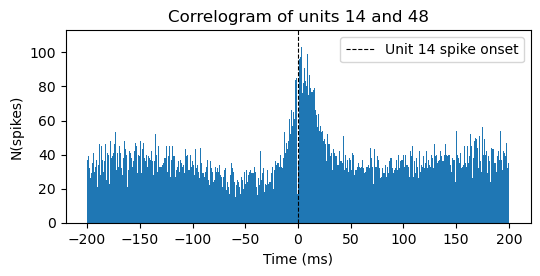

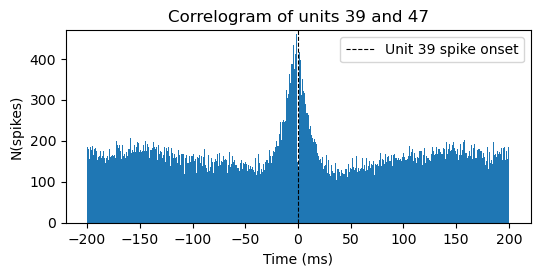

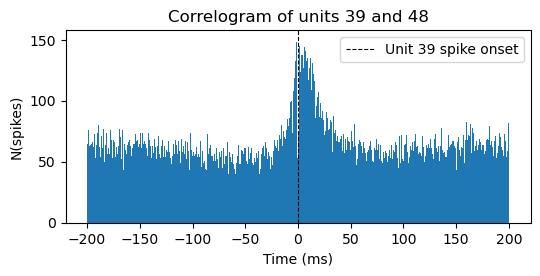

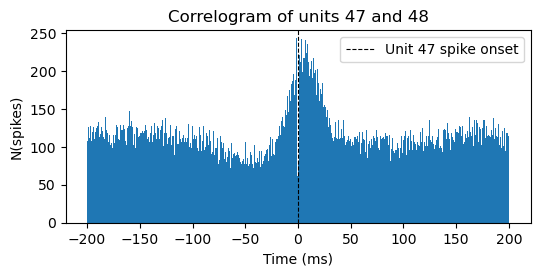

In [44]:
# showing more examples
for combo in unit_combos[1:]:
    u1, u2 = combo

    unit_1 = ex2.spike_data[u1]['rel_spike_time']
    unit_2 = ex2.spike_data[u2]['rel_spike_time']

    raster = ex2.raster(
        unit_1,
        unit_2,
        thresh = (-200,200),
    )
    
    fig, ax = plt.subplots(figsize = (6, 2.5))
    h, bins = np.histogram(raster, bins = np.arange(-200,201, 0.8))

    bin_centers = (bins[1:] + bins[:-1])/2
    ax.bar(bin_centers, h)
    ax.plot(
        np.full(400, 0), 
        np.linspace(0,h.max()+10,400), 
        '--', 
        color = 'black', 
        linewidth = 0.8,
        label = f"Unit {u1} spike onset"
    )
    ax.set_ylim(0,h.max()+10)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("N(spikes)")
    ax.legend()
    ax.set_title(f"Correlogram of units {u1} and {u2}")

<a id=13></a>
## 13) Making population response matricies
 [return to top](#top)

- You can get the peristimulus time histogram (PSTH) response of the entire population to a specific stimulus condition by using the population_response method on the experiment object.
- This method takes 5 arguments:
    - include_units: A list of cluster IDs to be included
    - stim_condition: A list of stimulus conditions to be included
    - columns: Set column label arrangement - pass either 'cluster_id' or 'stimulus_condition'
    - thresh: A tuple defining the time boundaries around 0 as the stimulus onset
    - norm: Normalization method. Enter: 'minmax', 'zscore', or 'average'

In [45]:
# include the single units given by the spike sorting criteria
include_units = single_units['index'].values

- First, let's make a population response matrix where the cluster id is in the columns. This can help us visualize how a stimulus triggers a response across the neural space.

In [46]:
pr = ex2.population_response(
            list(include_units),  # Units to include in the dataframe
            stim_condition=[condition],  # Stimulus condition(s) to include in the dataframe
            columns='cluster_id',  # Set column label arrangement
            thresh=(0,250),  # Bounding threshold around the stimulus onset at t = 0 - pass as a tuple
            norm='average'  # Normalization method - choose from: 'minmax', 'zscore', or 'average'
    )

- The output is a dataframe where each row is the PSTH response at time = t for the stimulus given in the stimulus_condition column and each other column is a cluster.
- Let's use pandas to visualize how this stimulus triggers a response across the neural space.

In [47]:
pr

,stimulus_condition,Orientation,Spatial Freq,Phase,2,4,6,7,11,14,...,42,44,45,47,48,50,51,75,77,79
0,347,150.0,0.02,0.5,0.000000,0.000000,11.049724,0.000000,0.000000,0.000000,...,0.000000,0.000000,11.049724,22.099448,5.524862,11.049724,0.000000,16.574586,5.524862,11.049724
1,347,150.0,0.02,0.5,0.000000,5.524862,0.000000,5.524862,0.000000,0.000000,...,5.524862,0.000000,5.524862,27.624309,11.049724,11.049724,11.049724,11.049724,0.000000,5.524862
2,347,150.0,0.02,0.5,0.000000,0.000000,5.524862,16.574586,0.000000,0.000000,...,22.099448,0.000000,0.000000,22.099448,0.000000,11.049724,16.574586,11.049724,0.000000,5.524862
3,347,150.0,0.02,0.5,11.049724,0.000000,5.524862,5.524862,0.000000,5.524862,...,0.000000,5.524862,0.000000,27.624309,5.524862,5.524862,5.524862,5.524862,16.574586,5.524862
4,347,150.0,0.02,0.5,16.574586,0.000000,0.000000,11.049724,0.000000,5.524862,...,5.524862,0.000000,16.574586,27.624309,11.049724,16.574586,0.000000,22.099448,5.524862,16.574586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,347,150.0,0.02,0.5,11.049724,5.524862,0.000000,5.524862,0.000000,0.000000,...,0.000000,0.000000,5.524862,22.099448,0.000000,0.000000,0.000000,5.524862,0.000000,11.049724
246,347,150.0,0.02,0.5,0.000000,0.000000,0.000000,11.049724,0.000000,5.524862,...,5.524862,0.000000,0.000000,11.049724,11.049724,5.524862,5.524862,11.049724,0.000000,11.049724
247,347,150.0,0.02,0.5,0.000000,5.524862,5.524862,27.624309,0.000000,0.000000,...,0.000000,5.524862,11.049724,16.574586,0.000000,5.524862,5.524862,5.524862,16.574586,5.524862
248,347,150.0,0.02,0.5,27.624309,0.000000,0.000000,5.524862,5.524862,0.000000,...,11.049724,0.000000,5.524862,16.574586,11.049724,0.000000,22.099448,11.049724,5.524862,5.524862


In [48]:
m = pr.values.T[4:] # skipping the columns with the condition id and parameters

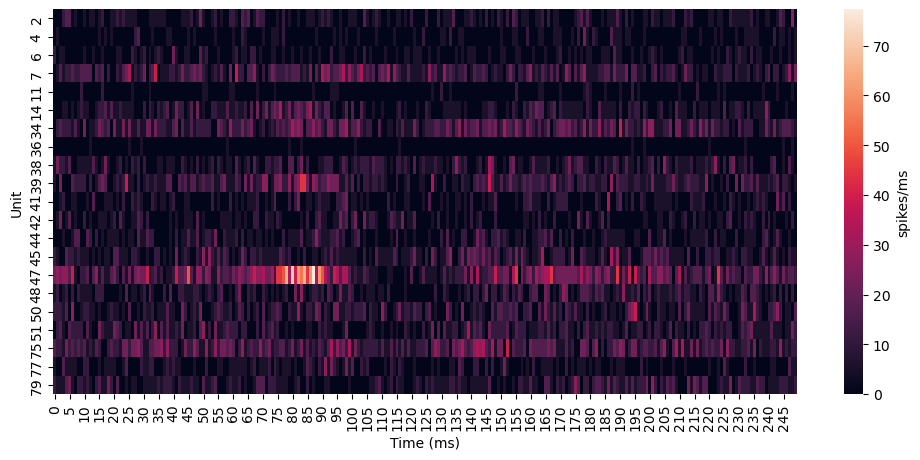

In [49]:
#plot the population response heatmap
fig, ax = plt.subplots(figsize = (12,5))

#transpose the array for a more typical rasterplot visualization
ax = sns.heatmap(m, cbar_kws={'label': 'spikes/ms'})
ax.set_yticks(np.arange(len(include_units))+0.5)
ax.set_yticklabels(include_units)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Unit")
plt.show()

- It is also possible to do this with all available stimulus conditions by switching the second argument to 'all'. Let's see what this looks like with the checkerboard experiment since there are fewer conditions.

In [50]:
pr = ex1.population_response(
            list(include_units),  
            stim_condition='all', 
            columns='cluster_id',  
            thresh=(0,500),  
            norm='average'
    )

In [51]:
pr

,stimulus_condition,2,4,6,7,11,14,34,36,38,...,42,44,45,47,48,50,51,75,77,79
0,1,10.0,5.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,5.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
1,1,10.0,5.0,0.0,0.0,10.0,20.0,0.0,25.0,5.0,...,0.0,10.0,0.0,5.0,0.0,5.0,5.0,10.0,0.0,15.0
2,1,5.0,10.0,0.0,0.0,0.0,5.0,0.0,20.0,5.0,...,0.0,0.0,0.0,10.0,0.0,5.0,10.0,20.0,0.0,15.0
3,1,20.0,5.0,10.0,0.0,10.0,0.0,0.0,20.0,0.0,...,0.0,0.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0
4,1,10.0,5.0,0.0,0.0,5.0,10.0,0.0,25.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,5.0,5.0,0.0,0.0,0.0,5.0,0.0,70.0,0.0,...,0.0,0.0,5.0,0.0,0.0,20.0,0.0,0.0,5.0,15.0
996,2,10.0,0.0,10.0,5.0,0.0,5.0,0.0,10.0,0.0,...,5.0,0.0,5.0,20.0,0.0,0.0,0.0,10.0,0.0,5.0
997,2,10.0,0.0,5.0,0.0,0.0,15.0,0.0,10.0,0.0,...,0.0,0.0,10.0,15.0,0.0,15.0,5.0,0.0,0.0,5.0
998,2,0.0,5.0,0.0,0.0,0.0,20.0,0.0,5.0,0.0,...,0.0,0.0,10.0,5.0,5.0,15.0,0.0,5.0,5.0,10.0


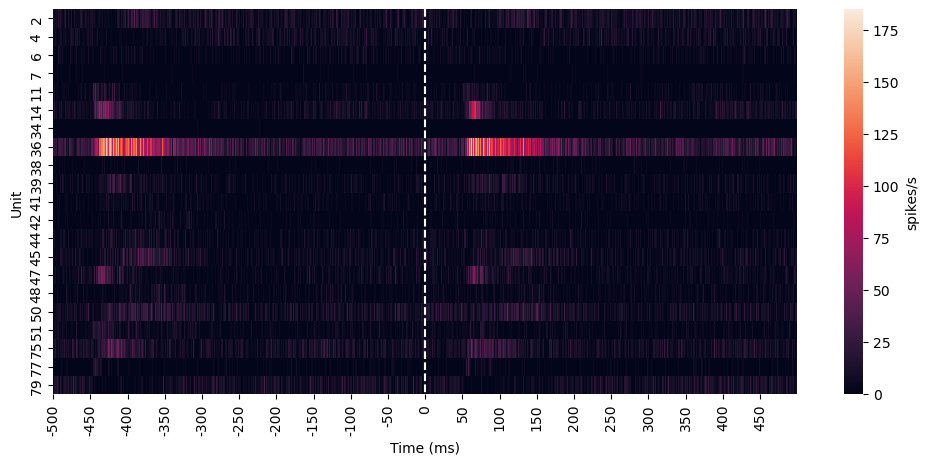

In [52]:
#plot the population response heatmap
fig, ax = plt.subplots(figsize = (12,5))

#transpose the array for a more typical rasterplot visualization
ax = sns.heatmap(pr.values.T[1:], cbar_kws={'label': 'spikes/s'})

#white dotted line showing the boundary between stimulus conditions
ax.plot([500]*1000, np.arange(1000), linestyle = '--', color = 'white')
ax.set_xticks(np.arange(0,1000,50))
ax.set_xticklabels(np.arange(-500,500,50))
ax.set_xlabel("Time (ms)")
ax.set_yticks(np.arange(len(include_units))+0.5)
ax.set_yticklabels(include_units)
ax.set_ylabel("Unit")
plt.show()

- You can also choose other normalizations including 'minmax' which constrains values between 0 and 1 and 'zscore' which transforms values to the number of standard deviations from the mean.

In [53]:
pr = ex1.population_response(
            list(include_units),  
            stim_condition='all', 
            columns='cluster_id',  
            thresh=(0,500),  
            norm='minmax'
    )

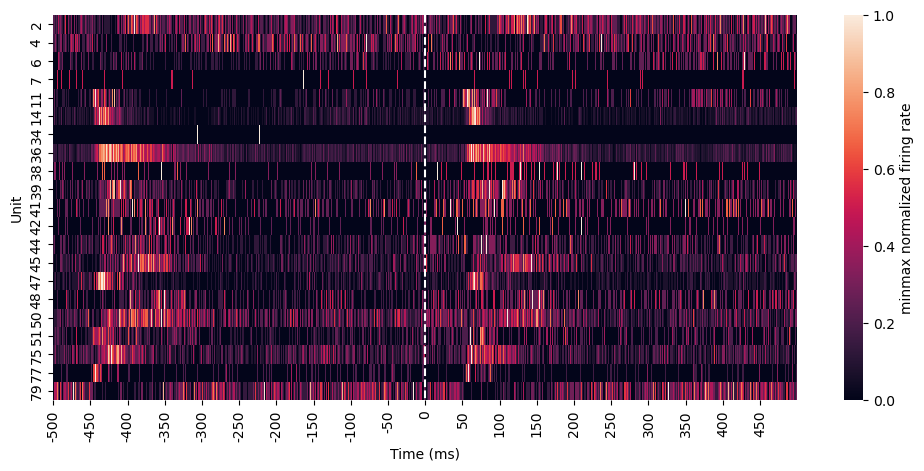

In [54]:
#plot the population response heatmap
fig, ax = plt.subplots(figsize = (12,5))

#transpose the array for a more typical rasterplot visualization
ax = sns.heatmap(pr.values.T[1:], cbar_kws={'label': 'minmax normalized firing rate'})

#white dotted line showing the boundary between stimulus conditions
ax.plot([500]*1000, np.arange(1000), linestyle = '--', color = 'white')
ax.set_xticks(np.arange(0,1000,50))
ax.set_xticklabels(np.arange(-500,500,50))
ax.set_xlabel("Time (ms)")
ax.set_yticks(np.arange(len(include_units))+0.5)
ax.set_yticklabels(include_units)
ax.set_ylabel("Unit")
plt.show()

-  We can use this to overlay the spiking data onto the LFP heatmap we made earlier:

/tmp/ipykernel_42679/102338076.py:21: RuntimeWarning: divide by zero encountered in divide
  normed_depth = depth*np.median(yticks/depth_info[::-1])


Text(0.5, 23.52222222222222, 'Time (ms)')

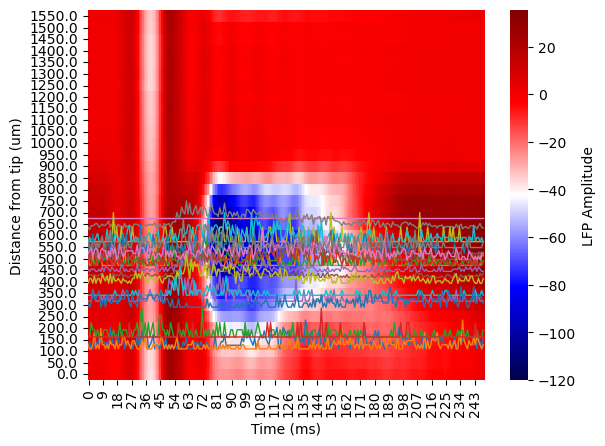

In [55]:
fig, ax = plt.subplots()

sns.heatmap(
    section['lfp_heatmaps'][0]['contrast0'][:,::20], 
    cmap = 'seismic',
    cbar_kws={'label': 'LFP Amplitude'},
)

yticks = np.arange(len(depth_info))+0.5
ax.set_yticks(yticks)
ax.set_yticklabels(depth_info, rotation = 0)
ax.set_ylabel("Distance from tip (um)")

for i, unit in enumerate(include_units):
    depth = (
        ex1.spike_data[unit]['depth'] # this gives the distance of the unit relative to the layer 4
        + project.l4_distances[0]['contrast0'] # this is the recorded layer 4 distance at the particular column
    )
    
    # normalize the depth to the y scale
    normed_depth = depth*np.median(yticks/depth_info[::-1])
    
    # shift the unit response relative to the depth
    unit_response = yticks[-1]-(2.5*(pr.values.T[1:][i])+normed_depth)
    ax.plot(unit_response[500:750], linewidth = 1)

#xticks = np.arange(0, 550, 50)
#xticklabels = xticks/20
#ax.set_xticks(xticks)
#ax.set_xticklabels(xticklabels)
ax.set_xlabel("Time (ms)")

- We can also generate a population response matrix with stimulus condition ids as the columns instead of cluster ids. This can help visualize how single units response across the entire stimulus space.
- Let's see what this looks like for a unit responding to a series of natural images.

In [56]:
pr = ex4.population_response(
            list(include_units),  
            stim_condition='all', 
            columns='stimulus_condition',  
            thresh=(-200,300),  
            norm='average'
    )

In [57]:
pr

,cluster_id,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,79,0.0,0.0,50.0,0.0,0.0,100.0,0.0,0.0,50.0,...,50.0,0.0,0.0,50.0,0.0,0.0,50.0,0.0,0.0,0.0
10496,79,0.0,50.0,50.0,0.0,0.0,100.0,0.0,0.0,100.0,...,0.0,50.0,0.0,0.0,0.0,50.0,50.0,100.0,0.0,50.0
10497,79,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,...,0.0,50.0,0.0,50.0,0.0,50.0,0.0,0.0,100.0,0.0
10498,79,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,50.0,0.0,50.0,50.0,50.0,0.0,0.0


- The output is a dataframe where each row is the PSTH response of the cluster given in the cluster_id column and each other column corresponds to a stimulus condition.
- Since it would be cumbersome to include the parameter values of each stimulus condition in the column, the stimulus parameters can instead be found in the parameter_map attribute:

In [58]:
ex4.parameter_map

,condition,size,filter,file
0,85.0,30,HPF,HPF_NI_ 62.tif.tif
1,356.0,60,NI,NI_ 97.tif.tif
2,195.0,30,LPF,LPF_NI_ 48.tif.tif
3,181.0,30,LPF,LPF_NI_ 34.tif.tif
4,18.0,60,HPF,HPF_NI_ 127.tif.tif
...,...,...,...,...
355,20.0,60,HPF,HPF_NI_ 128.tif.tif
356,278.0,60,NI,NI_ 142.tif.tif
357,164.0,60,LPF,LPF_NI_ 15.tif.tif
358,52.0,60,HPF,HPF_NI_ 24.tif.tif


- Let's visualize the response of a particular cluster across the stimulus space using the dataframe we just created:

In [59]:
unit = pr.loc[pr.cluster_id==51] #picking a cluster to plot the responses

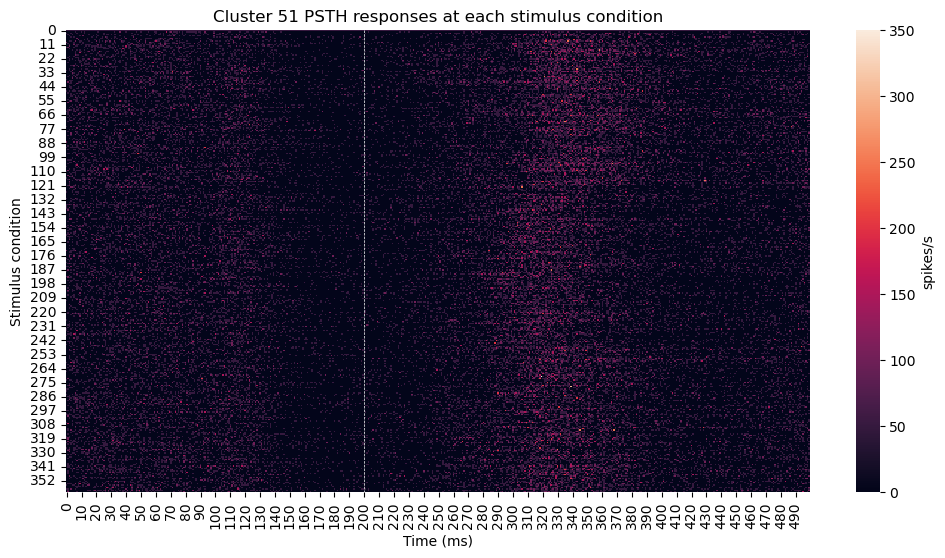

In [60]:
fig, ax = plt.subplots(figsize = (12,6))
ax = sns.heatmap(unit.values.T, cbar_kws = {'label': 'spikes/s'})
#ax.set_xticklabels(np.arange(-200,300,5))
ax.plot([200]*1000, np.arange(1000), linestyle = '--', color = 'white', linewidth = 0.5)
ax.set_title(f"Cluster 51 PSTH responses at each stimulus condition")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Stimulus condition")
plt.show()

<a id=14></a>
## 14) Temporal smoothing
 [return to top](#top)

- You can use the apply_temporal_smoothing on the experiment object to smooth a response or an array of responses over time.
- This method takes 3 arguments:
    - x: The response matrix
    - k: The smoothing kernel
    - t_axis: The temporal axis in the response matrix

In [61]:
unit_smoothed = ex3.apply_temporal_smoothing(
    x = unit, 
    k = np.ones(15)/15, 
    t_axis = 0
)

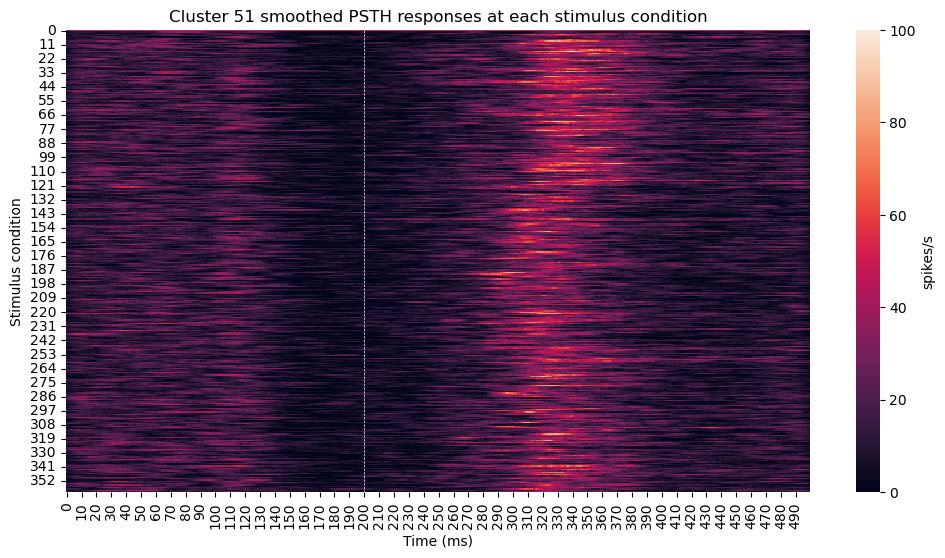

In [62]:
fig, ax = plt.subplots(figsize = (12,6))
ax = sns.heatmap(unit_smoothed.T, cbar_kws = {'label': 'spikes/s'})
#ax.set_xticklabels(np.arange(-200,300,5))
ax.plot([200]*1000, np.arange(1000), linestyle = '--', color = 'white', linewidth = 0.5)
ax.set_title(f"Cluster 51 smoothed PSTH responses at each stimulus condition")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Stimulus condition")
plt.show()

<a id=15></a>
## 15) Making tuning curves
 [return to top](#top)

- The population response method can conveniently be used to make tuning curves.
- First we can make a popululation response dataframe for a unit of choice (or multiple units).

In [63]:
unit = 51
pr = ex3.population_response(
            [unit],  
            stim_condition='all', 
            columns='cluster_id',  
            thresh=(0,300),  
            norm='average'
    )

- Next, we can groupby the stimulus parameters of interest, which are Spatial Frequency and Orientation in this example.
- We aggregate the mean, standard deviation and size.

In [64]:
df_tunings = pr.groupby(['Spatial Freq', 'Orientation'])[unit].agg([np.mean, np.std, np.size])

- Next we can use the standard deviation and size to calculate the standard error.

In [65]:
df_tunings['ste'] = df_tunings['std']/np.sqrt(df_tunings['size'])
df_tunings = df_tunings.reset_index()

In [66]:
df_tunings

,Spatial Freq,Orientation,mean,std,size,ste
0,0.02,0.0,15.333333,38.771549,300,2.238476
1,0.02,30.0,7.666667,27.877339,300,1.609499
2,0.02,60.0,19.666667,43.813479,300,2.529572
3,0.02,90.0,15.333333,39.624773,300,2.287737
4,0.02,120.0,9.000000,28.665993,300,1.655032
5,0.02,150.0,9.666667,31.779269,300,1.834777
6,0.02,180.0,5.333333,23.947173,300,1.382591
7,0.02,210.0,11.666667,33.179691,300,1.915630
8,0.02,240.0,11.000000,32.390799,300,1.870084
9,0.02,270.0,6.333333,24.396849,300,1.408553


- To make this dataframe easier to handle, we can turn it into a pivot table for the means and a pivot table for the errors:
- Since orientation is a circular variable, we will plot the tuning curves on a polar plot.

In [67]:
tuning_means = df_tunings.pivot_table(
    index = ['Orientation'], 
    columns = 'Spatial Freq', 
    values = 'mean'
).reset_index()

# make it circular by adding the first row to the end
tuning_means.loc[-1] = tuning_means.iloc[0]
tuning_means = tuning_means.set_index(['Orientation'])

tuning_errors = df_tunings.pivot_table(
    index = ['Orientation'], 
    columns = 'Spatial Freq', 
    values = 'ste'
).reset_index()

tuning_errors.loc[-1] = tuning_errors.iloc[0]
tuning_errors = tuning_errors.set_index(['Orientation'])

In [68]:
tuning_means

Spatial Freq,0.02,0.04,0.08,0.16,0.32
Orientation,,,,,
0.0,15.333333,8.333333,9.000000,13.333333,20.666667
30.0,7.666667,11.000000,11.000000,23.000000,22.333333
60.0,19.666667,14.666667,12.333333,11.000000,11.666667
90.0,15.333333,10.666667,10.666667,10.000000,15.666667
120.0,9.000000,5.666667,11.666667,13.666667,15.666667
150.0,9.666667,9.666667,9.666667,13.666667,20.000000
180.0,5.333333,6.666667,12.000000,9.333333,16.666667
210.0,11.666667,12.666667,10.666667,15.000000,20.333333
240.0,11.000000,7.000000,14.000000,9.000000,24.000000


Text(0.5, 1.0, 'Tuning curves for unit 51')

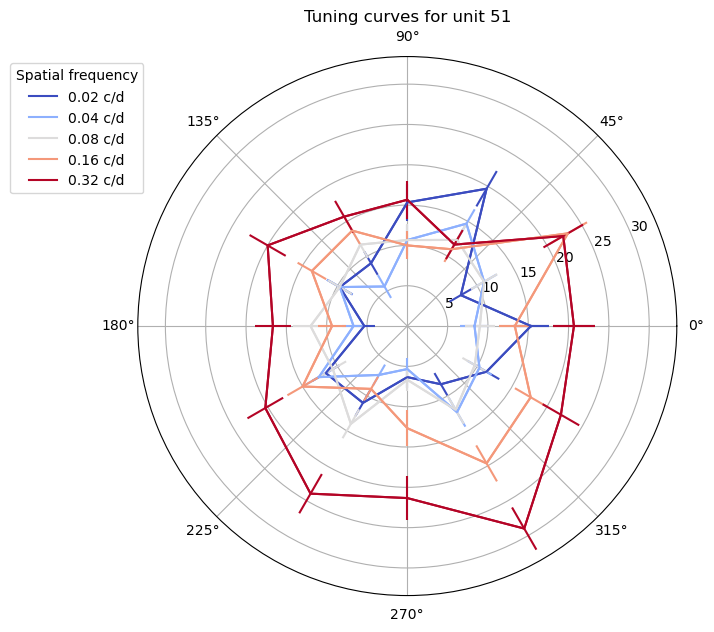

In [69]:
cmap = plt.get_cmap('coolwarm') 
colors = cmap(np.linspace(0, 1, 5))
fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': 'polar'})

sfs = np.array(tuning_means.columns)
oris = np.radians(np.array(tuning_means.index))
for i, sf in enumerate(sfs):
    ax.plot(oris, tuning_means[sf], label = f"{sf} c/d", color = colors[i])
    ax.errorbar(oris, tuning_means[sf], tuning_errors[sf], color = colors[i])
    
ax.legend(
    title = "Spatial frequency", 
    loc = 'upper left',
    bbox_to_anchor = (-0.25,1)
)
ax.set_title(f"Tuning curves for unit {unit}")

<a id=16></a>
## 16) Mapping receptive fields
 [return to top](#top)

- You can map spatiotemporal receptive fields by using the map_rf method on the experiment object.
- First you need a function of a unit's response across the stimulus space.
- We can get this by using the population_response method with columns set to 'stimulus_condition'.
- We'll show an example from experiment 2, because this experiment used flashing static gratings - a stimulus commonly used to map receptive fields.

In [70]:
pr = ex2.population_response(
            list(include_units),  
            stim_condition='all', 
            columns='stimulus_condition',  
            thresh=(0,250),  
            norm='average'
    )

In [71]:
# picking a cluster to plot the responses
# selecting all columns except the cluster_id column
unit = pr.loc[pr.cluster_id==47].T[1:] 

# apply temporal smoothing
unit = ex2.apply_temporal_smoothing(
    x = unit, 
    k = np.ones(15)/15, 
    t_axis = 1
)

- The map_rf method takes 6 arguments:
    - The unit response matrix, which must have the stimulus conditions in dim 0 and time in dim 1.
    - horizontal size in pixels
    - vertical size in pixels
    - horizontal size in degrees
    - vertical size in degrees
    - Circular diameter of the frame in degrees

In [72]:
rf = ex2.map_rf(
    unit,
    50,50, 
    72,72,
    50
)

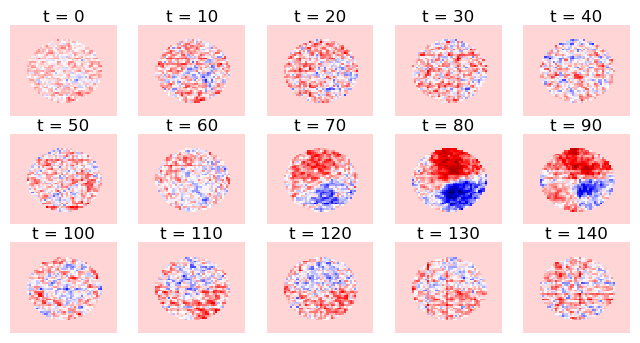

In [73]:
## Plot the receptive fields frames

fig, ax = plt.subplots(3, 5, figsize = (8, 4))
t_range = np.arange(0,160,10)

tpoint = 0
for row in range(3):
    for col in range(5):
        sns.heatmap(
            rf[:,:,t_range[tpoint]], 
            ax = ax[row, col], 
            cmap = 'seismic', 
            vmin = rf.min(), vmax = rf.max(),
            cbar = False
        )
        ax[row, col].set_title(f"t = {t_range[tpoint]}", fontsize = 12, y = 0.95)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        tpoint+=1

 [return to top](#top)